# Setting

In [1]:
!pip install netCDF4
!pip install cdlib
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00



> Imports



In [2]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import networkx as nx
from cdlib import algorithms

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}



> Connect to Google drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()


Mounted at /content/drive


'/content/drive/My Drive'

Variable Names:
longitude (192,)
latitude (144,)
field36 (144, 192)

Dimension Names and Sizes:
longitude 192
latitude 144
(112, 192)


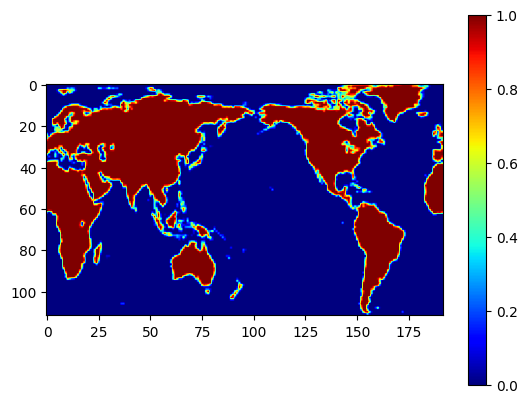

In [4]:
import netCDF4 as nc
import numpy as np

# Open the netCDF file
nc_file = nc.Dataset('JULES/CRU-NCEPv7.landfrac.nc', mode='r')

print('Variable Names:')
for var_name in nc_file.variables:
    var = nc_file.variables[var_name]
    print(var_name, var.shape)

print('\nDimension Names and Sizes:')
for dim_name in nc_file.dimensions:
    dim = nc_file.dimensions[dim_name]
    print(dim_name, len(dim))

var = nc_file.variables['field36'][27:-5,:]

# Close the netCDF file
nc_file.close()

# Convert the variable to a NumPy array
land_mask = np.array(var)

print(land_mask.shape)


# Create a heatmap plot of the NumPy array
plt.imshow(land_mask[::-1], cmap='jet')
plt.colorbar()
plt.show()

In [5]:
lightning_df = pd.read_csv('JULES/lightning.csv', index_col=0)
lightning_data = lightning_df.values
min_max_scaler_lightning = preprocessing.MinMaxScaler()
lightning_data = min_max_scaler_lightning.fit_transform(lightning_data)
lightning_data = np.array(lightning_data, dtype = np.float32)

lightning_data = np.reshape(lightning_data, (360, 144, 192, 1))
lightning_data = lightning_data[:, 27:-5, :, :]

In [6]:
lightning_data.shape

(360, 112, 192, 1)

In [7]:
import numpy as np

# Compressing data
def compress_data(data, land_mask):
    timesteps, height, width, _ = data.shape
    compressed_data = data.reshape(timesteps, -1)[:, land_mask.flatten() > 0]
    return compressed_data.reshape(timesteps, -1, 1)

compressed_data1 = compress_data(lightning_data, land_mask)

In [8]:
compressed_data1.shape

(360, 7771, 1)

In [9]:
# Decompress and mapping back to original shape
def decompress_data(compressed_data, land_mask):
    timesteps, _, _ = compressed_data.shape
    decompressed_data = np.zeros((timesteps, land_mask.size, 1))
    decompressed_data[:, land_mask.flatten()> 0, :] = compressed_data
    return decompressed_data.reshape(timesteps, land_mask.shape[0], land_mask.shape[1], 1)

decompressed_data1 = decompress_data(compressed_data1, land_mask)

20610
7452


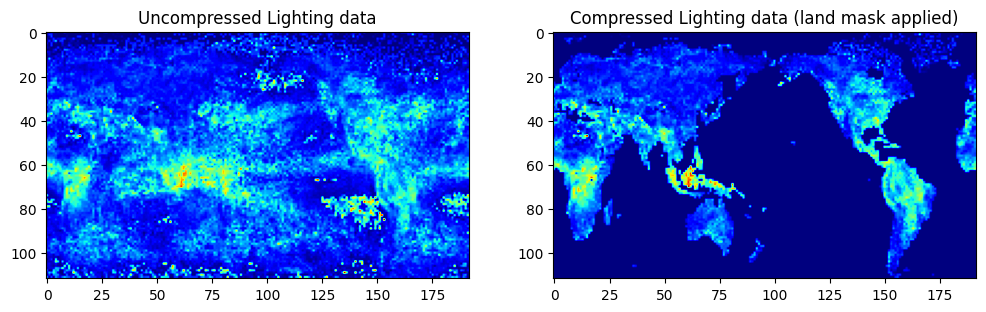

In [10]:
sum_array = np.sum(lightning_data, axis=0)
sum_array_compressed = np.sum(decompressed_data1, axis=0)

print(np.count_nonzero(sum_array))
print(np.count_nonzero(sum_array_compressed))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(sum_array[::-1], cmap='jet')
ax1.set_title('Uncompressed Lighting data')

im2 = ax2.imshow(sum_array_compressed[::-1], cmap='jet')
ax2.set_title('Compressed Lighting data (land mask applied)')

plt.show()

In [11]:
gb_df = pd.read_csv('JULES/gb_data.csv', index_col=0)
gb_data = gb_df.values
print(gb_data.shape)

scaler = preprocessing.MinMaxScaler()
gb_data = scaler.fit_transform(gb_data)
gb_data = np.array(gb_data, dtype = np.float32)

# 2
gb_df_2 = pd.read_csv('JULES/gb_data2.csv', index_col=0)
gb_data_2 = gb_df_2.values
print(gb_data_2.shape)

scaler_2 = preprocessing.MinMaxScaler()
gb_data_2 = scaler_2.fit_transform(gb_data_2)
gb_data_2 = np.array(gb_data_2, dtype = np.float32)

# 3
gb_df_3 = pd.read_csv('JULES/gb_data3.csv', index_col=0)
gb_data_3 = gb_df_3.values
print(gb_data_3.shape)

scaler_3 = preprocessing.MinMaxScaler()
gb_data_3 = scaler_3.fit_transform(gb_data_3)
gb_data_3 = np.array(gb_data_3, dtype = np.float32)

# 4
gb_df_4 = pd.read_csv('JULES/gb_data5.csv', index_col=0)
gb_data_4 = gb_df_4.values
print(gb_data_4.shape)

scaler_4 = preprocessing.MinMaxScaler()
gb_data_4 = scaler_4.fit_transform(gb_data_4)
gb_data_4 = np.array(gb_data_4, dtype = np.float32)

# 5
test_df = pd.read_csv('JULES/gb_data4.csv', index_col=0)
gb_data_test = test_df.values
print(gb_data_test.shape)

# Please note since the CAE-LSTM paper employed gb_data4 as test dataset
# For consistency we had adopted this, despite the impact on testing result is minimum

test_scaler = preprocessing.MinMaxScaler()
gb_data_test = test_scaler.fit_transform(gb_data_test)
gb_data_test = np.array(gb_data_test, dtype = np.float32)


gb_data = np.reshape(gb_data, (360, 112, 192, 1))
gb_data_2 = np.reshape(gb_data_2, (360, 112, 192, 1))
gb_data_3 = np.reshape(gb_data_3, (360, 112, 192, 1))
gb_data_4 = np.reshape(gb_data_4, (360, 112, 192, 1))
gb_data_test = np.reshape(gb_data_test, (360, 112, 192, 1))

# load the data
tair_df = pd.read_csv('JULES/tair.csv', index_col=0)
tair_data = tair_df.values
tair_data[np.isnan(tair_data)] = 0

min_max_scaler_tair = preprocessing.MinMaxScaler()
tair_data = min_max_scaler_tair.fit_transform(tair_data)
tair_data = np.array(tair_data, dtype = np.float32)

tair_data = np.reshape(tair_data, (360, 144, 192, 1))
tair_data = tair_data[:, 27:-5, :, :]

rain_df = pd.read_csv('JULES/rain.csv', index_col=0)
rain_data = rain_df.values
rain_data[np.isnan(rain_data)] = -0.001
min_max_scaler_rain = preprocessing.MinMaxScaler()
rain_data = min_max_scaler_rain.fit_transform(rain_data)
rain_data = np.array(rain_data, dtype = np.float32)

rain_data = np.reshape(rain_data, (360, 144, 192, 1))
rain_data = rain_data[:, 27:-5, :, :]

qair_df = pd.read_csv('JULES/qair.csv', index_col=0)
qair_data = qair_df.values
qair_data[np.isnan(qair_data)] = -0.001
min_max_scaler_qair = preprocessing.MinMaxScaler()
qair_data = min_max_scaler_qair.fit_transform(qair_data)
qair_data = np.array(qair_data, dtype = np.float32)

qair_data = np.reshape(qair_data, (360, 144, 192, 1))
qair_data = qair_data[:, 27:-5, :, :]

lightning_df = pd.read_csv('JULES/lightning.csv', index_col=0)
lightning_data = lightning_df.values
min_max_scaler_lightning = preprocessing.MinMaxScaler()
lightning_data = min_max_scaler_lightning.fit_transform(lightning_data)
lightning_data = np.array(lightning_data, dtype = np.float32)

lightning_data = np.reshape(lightning_data, (360, 144, 192, 1))
lightning_data = lightning_data[:, 27:-5, :, :]

(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)


In [12]:
gb_joint_data_1 = np.concatenate((gb_data, tair_data, rain_data, qair_data, lightning_data), axis = 3)
gb_joint_data_2 = np.concatenate((gb_data_2, tair_data, rain_data, qair_data, lightning_data), axis = 3)
gb_joint_data_3 = np.concatenate((gb_data_3, tair_data, rain_data, qair_data, lightning_data), axis = 3)
gb_joint_data_4 = np.concatenate((gb_data_4, tair_data, rain_data, qair_data, lightning_data), axis = 3)
test_joint_data = np.concatenate((gb_data_test, tair_data, rain_data, qair_data, lightning_data), axis = 3)

def compress_data(data):
    timesteps, height, width, features = data.shape
    compressed_data = data.reshape(timesteps, -1, features)[:, land_mask.flatten() > 0]
    return compressed_data.reshape(timesteps, -1, features)

# Mapping back to original shape
def decompress_data(compressed_data):
    timesteps, _, features = compressed_data.shape
    decompressed_data = np.zeros((timesteps, land_mask.size, features))
    decompressed_data[:, land_mask.flatten()> 0, :] = compressed_data
    return decompressed_data.reshape(timesteps, land_mask.shape[0], land_mask.shape[1], features)

train_joint_data = np.concatenate((gb_joint_data_1, gb_joint_data_2, gb_joint_data_3, gb_joint_data_4), axis = 0)
train_joint_data = compress_data(train_joint_data)
test_joint_data = compress_data(test_joint_data)
print(train_joint_data.shape)
print(test_joint_data.shape)

(1440, 7771, 5)
(360, 7771, 5)


In [13]:
# For Community detection
cov_joint_data = np.concatenate((gb_data, gb_data_2, gb_data_3, gb_data_4), axis = 0)

def compress_cov_data(data):
    timesteps, height, width, features = data.shape
    compressed_data = data.reshape(timesteps, -1, features)[:, land_mask.flatten() > 0]
    return compressed_data.reshape(timesteps, -1)

cov_joint_data = compress_cov_data(cov_joint_data)
print(cov_joint_data.shape)

(1440, 7771)


In [14]:
np.save('JULES/GCN_LSTM_Paper/dataset/cov_joint_data.npy', cov_joint_data)
np.save('JULES/GCN_LSTM_Paper/dataset/train_data_landed_v2.npy', train_joint_data)
np.save('JULES/GCN_LSTM_Paper/dataset/test_joint_data_landed_v2.npy', test_joint_data)

In [15]:
covariance_matrix = np.cov(cov_joint_data.T)
covariance_matrix.shape

(7771, 7771)

In [16]:
mean = np.mean(covariance_matrix)
print(np.mean(covariance_matrix))
print(np.min(covariance_matrix))
print(np.max(covariance_matrix))

0.00017769198321487126
-0.03937217678808987
0.07340885431106133


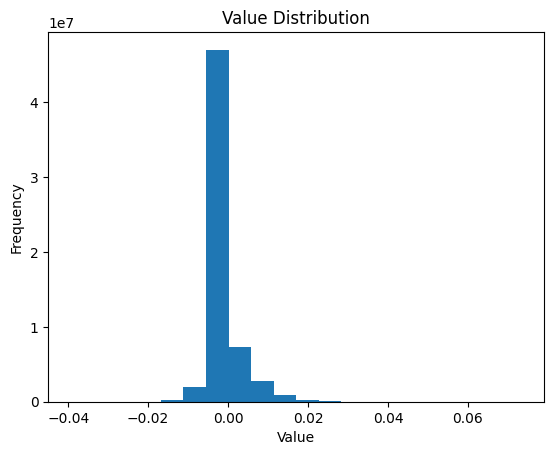

In [17]:
# Flatten the array to a 1D array
flat_array = covariance_matrix.flatten()

# Create a histogram of the flattened array
plt.hist(flat_array, bins=20)

plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

In [18]:
correlation_matrix = covariance_matrix.copy()

In [19]:
from sklearn.preprocessing import MinMaxScaler
cov_scaler = preprocessing.MinMaxScaler()
correlation_matrix = cov_scaler.fit_transform(correlation_matrix)
mean = np.mean(covariance_matrix)
print(mean)

0.00017769198321487126


In [20]:
threshold = 0.51
# Set values smaller than the threshold to 0.51, 0.1 quantile
# correlation_matrix = abs(covariance_matrix)
correlation_matrix[abs(correlation_matrix) < threshold ] = 0.0
print(np.count_nonzero(covariance_matrix))
print(np.count_nonzero(correlation_matrix))

51739249
4926884


In [21]:
print(np.mean(correlation_matrix))
print(np.min(correlation_matrix))
print(np.max(correlation_matrix))

0.050909294923474346
0.0
1.0000000000000002


In [22]:
print(np.mean(correlation_matrix))
print(np.min(correlation_matrix))
print(np.max(correlation_matrix))

0.050909294923474346
0.0
1.0000000000000002


In [23]:
print(np.count_nonzero(covariance_matrix))
print(np.count_nonzero(correlation_matrix))

51739249
4926884


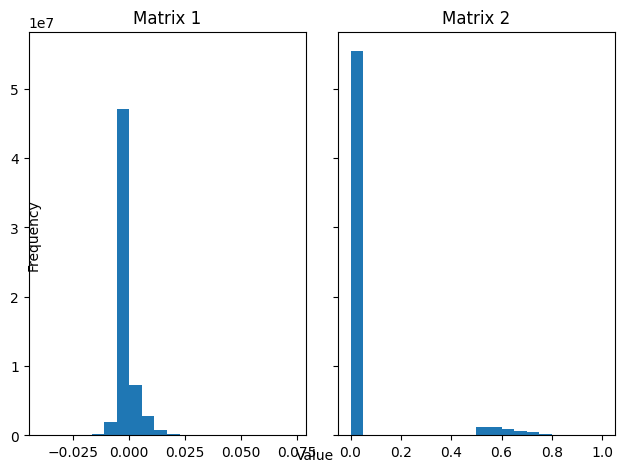

In [24]:
import matplotlib.pyplot as plt
import numpy as np

flat_array1 = covariance_matrix.flatten()
flat_array2 = correlation_matrix.flatten()

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# Create histograms of the flattened arrays
axs[0].hist(flat_array1, bins=20)
axs[0].set_title('Matrix 1')

axs[1].hist(flat_array2, bins=20)
axs[1].set_title('Matrix 2')

fig.text(0.5, 0.04, 'Value', ha='center', va='center')
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')

plt.show()

In [25]:
def create_sparse_graph(matrix):
    G = nx.Graph()
    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(i + 1, cols):
            if matrix[i, j] != 0.0:
                G.add_edge(i, j, weight=matrix[i, j])
    return G

# Create a sparse graph from the adjacency matrix (correlation_matrix)
sparse_G = create_sparse_graph(correlation_matrix)
sparse_G.number_of_nodes()

5513

In [26]:
sparse_G.number_of_edges()

2432830

In [34]:
# Apply the Louvain community detection algorithm
communities = algorithms.louvain(sparse_G, resolution = 1.39)

In [35]:
# Create a dictionary to map node to community
num_community = 0
node_community_map = {}
for community_id, community in enumerate(communities.communities):
  if community_id > num_community:
    num_community = community_id
    for node in community:
        node_community_map[node] = community_id

In [36]:
unique_communities = set(node_community_map.values())
num_communities = len(unique_communities)
print(f'There are {num_communities} unique communities.')

There are 6 unique communities.


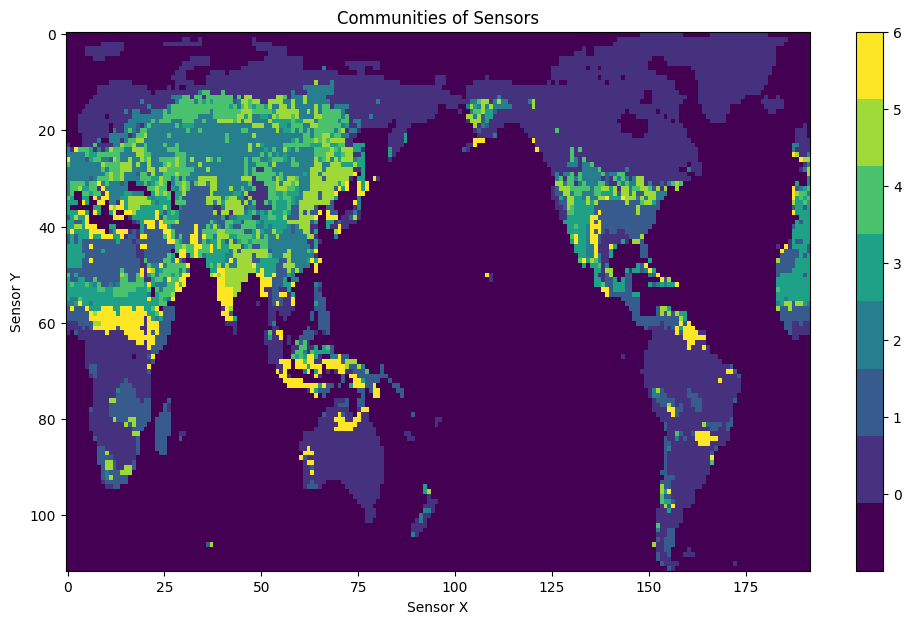

In [37]:
community_grid = np.zeros((112, 192), dtype=int)

node_index = 0
for i in range(112):
    for j in range(192):
      if land_mask[i, j] > 0:
        if node_index in node_community_map:
          community_grid[i, j] = node_community_map[node_index]
        node_index += 1
      else:
        community_grid[i, j] = -1
import matplotlib.colors as mcolors

def plot_communities(community_grid):
    # Reverse the order of the rows
    community_grid = community_grid[::-1]
    num_communities = len(set(community_grid.flatten()))
    cmap = plt.get_cmap('viridis', num_communities)

    fig, ax = plt.subplots(figsize=(12, 7))
    cax = ax.imshow(community_grid, cmap=cmap, aspect='auto')

    cbar = fig.colorbar(cax, ticks=range(num_communities))
    cbar.ax.set_yticklabels(range(num_communities))
    plt.xlabel('Sensor X')
    plt.ylabel('Sensor Y')
    plt.title('Communities of Sensors')

    plt.show()

plot_communities(community_grid)

In [38]:
import torch
# Get the edge indices and convert to tensor
edge_index = torch.tensor(list(sparse_G.edges()), dtype=torch.long).t().contiguous()

# Get the edge weights
weights = nx.get_edge_attributes(sparse_G, 'weight')

# Get them in the order of edge_index
edge_weight = torch.tensor([weights[(i,j)] for i,j in edge_index.t().tolist()], dtype=torch.float)

print(edge_index)
print(edge_weight)

tensor([[   0,    0,    0,  ..., 4442, 4442, 6206],
        [   1,    2,    8,  ..., 6206, 6365, 6365]])
tensor([0.6501, 0.8787, 0.8539,  ..., 0.6040, 0.6359, 0.5310])


In [39]:
edge_index.shape

torch.Size([2, 2432830])

In [40]:
torch.save({'edge_index': edge_index, 'edge_weight': edge_weight}, 'JULES/GCN_LSTM_Paper/dataset/ver_sparse_graph_data_v6.pt')